# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Determinación-de-los-parámetros-de-los-polarizadores-lineales" data-toc-modified-id="Determinación-de-los-parámetros-de-los-polarizadores-lineales-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Determinación de los parámetros de los polarizadores lineales</a></div><div class="lev2 toc-item"><a href="#Tarjeta-de-adquisición-de-datos" data-toc-modified-id="Tarjeta-de-adquisición-de-datos-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tarjeta de adquisición de datos</a></div><div class="lev2 toc-item"><a href="#Parametros-iniciales" data-toc-modified-id="Parametros-iniciales-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Parametros iniciales</a></div><div class="lev2 toc-item"><a href="#Motores" data-toc-modified-id="Motores-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Motores</a></div><div class="lev2 toc-item"><a href="#Rotación-de-P4---referencia-motor" data-toc-modified-id="Rotación-de-P4---referencia-motor-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Rotación de P4 - referencia motor</a></div><div class="lev2 toc-item"><a href="#Rotación-de-P4---referencia-polarizador" data-toc-modified-id="Rotación-de-P4---referencia-polarizador-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Rotación de P4 - referencia polarizador</a></div><div class="lev2 toc-item"><a href="#Final" data-toc-modified-id="Final-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Final</a></div>

# Medir un elemento de polarizacion

**Autor**: Jesús del Hoyo

**Fecha**:   06/02/2019

**Objetivo**: Ecograb project, polariscope callibration

**Configuración**:

Se puede utilizar tanto en transmisión como en reflexión, empleando el fotodiodo como detector.

**Elementos ópticos**:
1. Diodo láser de Roithner .... de longitud de onda $\lambda$=850 nm.
1. Lente colimadora de Thorlabs DG10-600-B.
1. Polarizador 0 LPNIRE100-B.
1. Retardador  0 $\lambda/4$ Thorlabs WPQ10E-850-SP.
1. Polarizador 1 LPNIRE100-B (P1).
1. Retardador  1 $\lambda/4$ Thorlabs WPQ10E-850-SP (R1).
1. Elementos previos a la muestra. Deben estar caracterizados para que el análisis funcione.
1. MUESTRA. 
1. Elementos posteriores a la muestra. Deben estar caracterizados para que el análisis funcione.
1. Retardador  2 $\lambda/4$ Thorlabs WPQ10E-850-SP (R2).
1. Polarizador 2 LPNIRE100-B (P2).
1. Fotodiodo (ver cual).



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import pprint

from polaripython.utils import dibujar_2d_fitting, sort_positions, plot_2d_scattered, generate_even_distribution
from polaripython.polarimeter import get_calibration, degrees, polarimeter_experiment, Intensity_Rotating_Elements
from py_pol.stokes import Stokes

from scipy import optimize

2.0.2


## Preparar los experimentos

### Tarjeta de adquisición de datos.

In [3]:
from polaripython.daca import u3, LabJackPython, get_intensity, V, mV

In [4]:
# loads labjack
d=u3.U3()
data_callibration=d.getCalibrationData()
AIN_signal=1
AIN_ref=2

# print("\n Callibration data:")
# pprint.pprint(data_callibration)

## Check that daca is working
# 
ain1bits, = d.getFeedback(u3.AIN(AIN_signal)) # Read from raw bits from AIN0
ainValue = d.binaryToCalibratedAnalogVoltage(ain1bits, isLowVoltage = False, channelNumber = 0)
print(ainValue)
ain1bits, = d.getFeedback(u3.AIN(AIN_ref)) # Read from raw bits from AIN0
ainValue = d.binaryToCalibratedAnalogVoltage(ain1bits, isLowVoltage = False, channelNumber = 0)
print(ainValue)

2.98947688309
4.33009064314


### Motores

In [5]:
from polaripython.motors.rotary_motors import Motors
Comports = [3, 4, 5, 7] 
Vels=[50,50,50,50]

In [6]:
motors = Motors(RS232_COMPORT=Comports, init_vels=Vels) 

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0



### Parametros iniciales

In [7]:
%pwd

u'C:\\Users\\luismiguel\\software\\polaripython\\polaripython\\motors'

In [8]:
# Load calibration file
path_absolute = 'C:\Users\luismiguel\software\polaripython'
pol_dict=get_calibration(path_absolute + '\\polaripython', verbose=True)
# Extract initial angles
theta1 = pol_dict["th0p1"]/degrees # Change with future calibrations
theta2 = pol_dict['th0r1']/degrees
theta3 = pol_dict['th0r2']/degrees
theta4 = pol_dict['th0p2']/degrees # Change with future calibrations
theta0 = np.array([theta1, theta2, theta3, theta4])
print("theta_1={}º, theta_2={}º, theta_3={}º, theta_4={}º".format(theta1, theta2, theta3, theta4))
try:
    Mbefore = pol_dict['Mbefore']
except:
    Mbefore = Mueller('Mbefore')
    Mbefore.from_matrix(np.eye(4))
try:
    Mafter = pol_dict['Mafter']
except:
    Mafter = Mueller('Mafter')
    Mafter.from_matrix(np.eye(4))

# Extract simulation parameters
# Mr2 = ps.Mueller_Real_Retarder(pol_dict["R2p1"], pol_dict["R2p2"], pol_dict["Dr2"])
Mpol = [pol_dict["Mp1"], pol_dict["Mr1"], pol_dict["Mr2"], pol_dict["Mp2"]]  # Fix in future calibrations
Mall = [Mbefore, pol_dict["Mp1"], pol_dict["Mr1"], pol_dict["Mr2"], pol_dict["Mp2"], Mafter]
# Mpol = [pol_dict["Mp1"], pol_dict["Mr1"], Mr2, pol_dict["Mp2"]]
Ifuente = pol_dict["Ifuente"]
print(Ifuente)
# Calculate date for filenames
fecha = datetime.date.today()

Old calibration
Using default (vacuum) Mbefore and Mafter
Calibration loaded succesfully
theta_1=172.021436036º, theta_2=162.672244914º, theta_3=55.7851264893º, theta_4=35.6896552035º
I0 = [+4.283; +0.300; +0.302; +4.261]



### Sistema de archivos

Es muy deseable crear una carpeta que contenga todos los archivos de una misma calibracion. Tenemos tres tipos de archivos diferentes: este mismo notebook, que guarda las instrucciones dadas a los motores. Están también los archivos npz en que se guardan los datos experimentales y que son importables por python. Y por último, está el script usado para realizar los calculos para determinar la matriz de Mueller, del que también merece la pena guardar una copia por si se modifica en el futuro.

En este paso, creamos la carpeta y colocamos ahí el directorio activo, de tal manera que se guarden ahí todos los datos.

In [9]:
# Paths and names
path_medidas = path_absolute + '\\medidas_0D'
new_folder = 'Medidas_{}'.format(fecha)
path_medidas_new = path_medidas + '\\' + new_folder
path_process = path_absolute + '\\polarimeter'
name_notebook = 'Medir_Mueller_Fotodiodo_1.0.ipynb'
name_process = 'data_process.py'
# Save bookmarks
%bookmark absolute $path_absolute
%bookmark medidas $path_medidas
%bookmark med_folder $path_medidas_new
%bookmark process $path_process
%bookmark -l -
# Create calibration folder
%cd medidas
%mkdir $new_folder
%cd med_folder

Current bookmarks:
absolute   -> C:\Users\luismiguel\software\polaripython
med_folder -> C:\Users\luismiguel\software\polaripython\medidas_0D\Medidas_2019-03-11
medidas    -> C:\Users\luismiguel\software\polaripython\medidas_0D
process    -> C:\Users\luismiguel\software\polaripython\polarimeter
(bookmark:medidas) -> C:\Users\luismiguel\software\polaripython\medidas_0D
C:\Users\luismiguel\software\polaripython\medidas_0D
(bookmark:med_folder) -> C:\Users\luismiguel\software\polaripython\medidas_0D\Medidas_2019-03-11
C:\Users\luismiguel\software\polaripython\medidas_0D\Medidas_2019-03-11


Ya existe el subdirectorio o el archivo Medidas_2019-03-11.


### Otros

In [10]:
def medir_intensidades(verbose=True):
    I = np.array(
        [get_intensity(d=d, u=u3, AIN_number=AIN_signal, verbose=verbose), 
         get_intensity(d=d, u=u3, AIN_number=AIN_ref, verbose=verbose)]
    )
    return I

def generar_dict_de_param(analysis=False):
    dictionary = {}
    dictionary["Iexp"] = I
    dictionary["theta0"] = theta0
    dictionary["Nmedidas"] = N
    dictionary["type_array_angles"] = type_angles
    dictionary["type_motor_angles"] = mode_motors
    dictionary["limits"] = limits
    dictionary["Nlimit"] = Nlimit
    dictionary["Imodel"] = Imodel
    dictionary["Measure_file"] = name_notebook    
    dictionary["calibration_data"] = pol_dict
    try:
        dictionary["date_cal"] = pol_dict["Date"]
    except:
        dictionary["date_cal"] = 'Unknown'
    if analysis:
        dictionary["Mcalculated"] = Mcalculated.M
        dictionary["Mnormalized"] = Mnormalized.M    
        dictionary["Mfiltered"] = Mfiltered.M       
        dictionary["Mp"] = Mp.M       
        dictionary["Mr"] = Mr.M       
        dictionary["Md"] = Md.M    
        dictionary["tol_filter"] = tol_filter    
        dictionary["is_vacuum"] = is_vacuum 
        dictionary["daily_transmission"] = daily_transmission
        dictionary["Mbefore"] = Mbefore.M  
        dictionary["Mafter"] = Mafter.M  
    return dictionary
    

**Iluminación**

Poner la fuente al mismo voltaje y corriente que durante la calibración.

T = 25 deg C.

I = 270 mA.

## Experimento de medida de matriz de polarización

Aquí vamos a tomar una serie de medidas para calcular la matriz de Mueller de una muestra.

In [11]:
# Background level
motors.move(
        positions = -theta0, 
        velocities=Vels, kind='absolute',  verbose=False)
intensity_0 = medir_intensidades()

-0.0192, 0.0166, 

In [21]:
# test
motors.move(
        positions = -theta0, #th0_exp, 
        velocities=Vels, kind='absolute',  verbose=False)
_ = medir_intensidades()
# motors.move(
#         positions = th0_exp, 
#         velocities=Vels, kind='absolute',  verbose=False)
# _ = medir_intensidades()

0.8097, 4.5194, 

motor     = (-172.01, 162.68,  55.78, -35.68)
absolute  = (-172.01, -162.68, -55.78, -35.68)
polarizer = (  0.01,  -0.00,   0.00,   0.01)
0.1292, 4.4682, 0.0064, 4.4529, 0.4669, 4.4222, 0.5794, 4.4375, 0.1240, 4.4529, 0.2417, 4.4734, -0.0039, 4.4222, 0.2315, 4.4427, 0.0729, 4.4682, 0.2673, 4.4580, 0.6869, 4.4529, 0.7278, 4.4427, 0.8199, 4.4324, 0.7688, 4.4324, 0.8046, 4.4375, 0.5999, 4.4478, 0.0780, 4.4273, 0.0524, 4.4478, 0.7176, 4.4682, 0.6613, 4.4529, 0.8251, 4.4682, 0.6562, 4.4478, 0.5180, 4.4580, 0.5948, 4.4580, 0.7381, 4.4273, 0.8455, 4.4427, 0.3594, 4.4375, 0.1189, 4.4324, 0.4669, 4.4375, 0.6101, 4.4324, 0.6101, 4.4324, 0.6869, 4.4478, 0.4822, 4.4682, 0.1650, 4.4529, 0.0422, 4.4529, 0.7688, 4.4324, 0.5692, 4.4375, 0.5641, 4.4785, 0.3748, 4.4631, 0.6715, 4.4734, 0.2059, 4.4324, 0.5743, 4.4682, 0.5027, 4.4375, 0.5948, 4.4785, 0.4566, 4.4580, 0.4106, 4.4427, 0.3441, 4.4580, 0.2775, 4.4375, -0.0090, 4.4580, 0.0831, 4.4734, 0.3134, 4.4580, 0.2161, 4.4734, 0.5846, 4.4580, 0.8097, 4.44

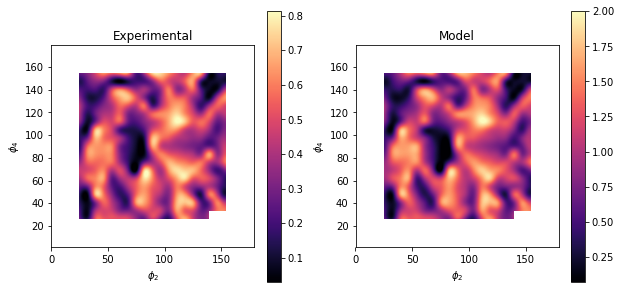

In [22]:
# Parámetros
N = 200 # Numero de medidas
todos = False # Mover todos los motores (True) o solo los de los rotadores (False).
#filename="Polarizador_LPNIRE100B_60deg_lrandom_{}".format(datetime.date.today())
#filename="Difusor_DG10-600B_0deg_random_{}".format(datetime.date.today())
#filename="Retardador_WQ10E-850-SP_30deg_random_{}".format(datetime.date.today())
#filename="Papel_linear_ret_{}".format(datetime.date.today())
# filename="Aire_transmision_{}".format(datetime.date.today())
# filename="Cubo_CCM1-BSO14_ref_{}".format(datetime.date.today())
filename="Espejo_90deg_{}".format(datetime.date.today())
#filename="Polarizador_malo_90deg_linear_ret_{}".format(datetime.date.today())
is_vacuum = False
type_angles = 'random'
mode_motors = 'absolute'
limits = [180, 180, 180, 180]
Nlimit = [0, 0, 0, 0]

# Preparar los ángulos aleatorios
if type_angles == 'Random' or 'random':
    angles = np.random.rand(N,4)*limits
else:
    angles = generate_even_distribution(Nmeasures=N, limits=limits, method=type_angles, N_total_motors=4)
#print(angles)
# Ordenarlos
pos_ini = motors.get_position()
angles = sort_positions(angles, pos_ini[1])

# Empezar a medir
I = np.zeros([N,2])
Imodel = np.zeros(N)
for ind in range(N):
    angles_ind = np.array([angles[ind,0], angles[ind,1], angles[ind,2], angles[ind,3]])
    angles_all = np.array([0, angles[ind,0], angles[ind,1], angles[ind,2], angles[ind,3], 0])
    motors.move(
        positions = angles_ind - theta0, 
        velocities=Vels, kind=mode_motors,  verbose=False)
    I[ind,:] = medir_intensidades()
    Imodel[ind] = Intensity_Rotating_Elements(Mall, angles_all*degrees, Ei=Ifuente)
I = I - intensity_0
param = generar_dict_de_param()
I_to_fit = I[:,0] * np.mean(I[:,1]) / I[:,1]

# Save data (just in case there is some problem afterwards)
np.savez(filename+'.npz', angulos = angles, parametros = param, intensidad=I_to_fit)
print("\nExperimento concluido con exito")

# Plot result
cond1 = (limits[0] == 0 and limits[3] == 0) or (Nlimit[0] <= 1 and Nlimit[3] <= 1)
if cond1:    
    plt.figure(figsize=(10, 5))       
    plt.subplot(1,2,1)
    plot_2d_scattered(angles[:,1], angles[:,2], I_to_fit, xy_are_angles=False)    
    plt.title('Experimental')   
    plt.subplot(1,2,2)   
    plot_2d_scattered(angles[:,1], angles[:,2], Imodel, xy_are_angles=False)  
    plt.title('Model')  

## Analisis

En esta parte analizamos la medida realizada y calculamos la matriz de Mueller.

In [18]:
# Initialize data
tol_filter = 1e-3
# Initialize daily_transmission if it does not exist
if not is_vacuum:
    try:
        daily_transmission = 1.54
        print("Daily transmission: {}".format(daily_transmission))
    except:
        daily_transmission = 1.32
# Recompose data
angles_to_fit = np.array(angles)*degrees
# Calculate Mueller Matrix
Mcalculated = polarimeter_experiment(M=Mpol, illum=Ifuente, I=I_to_fit, th=angles_to_fit, 
                                     Mbefore=Mbefore, Mafter=Mafter)
print(Mcalculated)
if is_vacuum:
    daily_transmission = Mcalculated.M[0,0]
    print("Daily transmission: {}\n\n".format(daily_transmission))
    Mtarget = np.eye(4)
Mnormalized = Mcalculated / daily_transmission
Mnormalized.name= 'Normalized'
print(Mnormalized)
if is_vacuum:
    error = np.linalg.norm(Mtarget-Mnormalized.M)/16
    print("RMS error of normalized matrix: {}\n\n".format(error))
# Filter it
Mfiltered = Mnormalized.analysis.filter_physical_conditions(tol=tol_filter, verbose=False)
Mfiltered.name= 'Filtered'
print(Mfiltered)
if is_vacuum:
    error = np.linalg.norm(Mtarget-Mfiltered.M)/16
    print("RMS error of filtered matrix: {}\n\n".format(error))
# Analyze filtered matrix
Md, Mr, Mp = Mfiltered.analysis.decompose_polar(decomposition='DRP', 
                                                verbose=True, give_all=False, tol=tol_filter, filter=False)
# Save the data in the same file
param = generar_dict_de_param(analysis=True)
np.savez(filename+'.npz', angulos = angles, parametros = param, intensidad=I)
print("\n                                                                         Analisis concluido con exito")

Daily transmission: 1.54
Calculated = 
  [+1.2257, -0.0298, -0.0312, -0.0003]
  [-0.0240, -0.3898, +1.0991, +0.3530]
  [-0.0374, +1.1011, +0.4938, -0.2494]
  [+0.0047, -0.3513, +0.2316, -1.1352]

Normalized = 
  [+0.7959, -0.0194, -0.0203, -0.0002]
  [-0.0156, -0.2531, +0.7137, +0.2292]
  [-0.0243, +0.7150, +0.3207, -0.1620]
  [+0.0031, -0.2281, +0.1504, -0.7372]

Filtered = 
  [+0.8000, -0.0193, -0.0208, -0.0007]
  [-0.0149, -0.2547, +0.7121, +0.2262]
  [-0.0242, +0.7133, +0.3178, -0.1599]
  [+0.0027, -0.2311, +0.1524, -0.7366]

------------------------------------------------------
General case.
Polar decomposition of the matrix M = Mdesp * Mr * Mp:

The depolarizer Mueller matrix is:
depolarizer = 
  [+1.0000, +0.0000, +0.0000, +0.0000]
  [-0.0029, +0.9872, +0.0064, +0.0006]
  [+0.0014, +0.0064, +0.9965, +0.0012]
  [+0.0005, +0.0006, +0.0012, +0.9842]

Parameters:
  - Polarizance = 0.00332569639224.
  - Depolarization degree = 0.145775547011.

The retarder Mueller matrix is:
retarde

In [45]:
# Save as matrix before
Mbefore = Mfiltered * Mbefore

In [65]:
# Save as matrix after
# Mafter = Mafter * Mfiltered
Mafter = M_cube_tansmission.reciprocal(keep=True, returns_matrix=False)
X_mueller = np.matrix(np.diag([1, 1, -1, 1]))
mafter = X_mueller * M_cube_tansmission.M.T * X_mueller
Mafter.from_matrix(mafter)
print(M_cube_tansmission, Mafter)

Filtered = 
  [+0.9864, +0.0011, +0.0135, +0.0008]
  [+0.0021, +0.9768, -0.0148, +0.1107]
  [+0.0134, +0.0139, +0.9585, -0.0509]
  [+0.0004, -0.1082, +0.0535, +0.9535]
 M = 
  [+0.9864, +0.0021, -0.0134, +0.0004]
  [+0.0011, +0.9768, -0.0139, -0.1082]
  [-0.0135, +0.0148, +0.9585, -0.0535]
  [+0.0008, +0.1107, +0.0509, +0.9535]



In [40]:
# Save as other
M_cube_tansmission = Mfiltered

In [ ]:
print(M_cube_tansmission)
M_cube_tansmission.analysis.decompose_polar(decomposition='DRP', 
                                                verbose=True, give_all=False, 
                                            tol=tol_filter, filter=False)

## Final

Ahora vamos a copiar el script utilizado para realizar el ajuste, y este notebook. IMPORTANTE: Comprueba los nombres de archivo y localizaciones, no pueden guardarse en variables y hay que cambiarlo manualmente ahora. 

In [34]:
# Recordar fecha para nombre de archivos
fecha = datetime.date.today()
print(fecha)

2019-02-07


In [37]:
# Go to script folder
%cd process
# Copy the file
%copy $name_process $path_medidas_new
# Go to notebook folder
%cd medidas
# Copy the file
%copy $name_notebook $path_medidas_new

(bookmark:process) -> C:\Users\luismiguel\software\polarimeter\polarimeter
C:\Users\luismiguel\software\polarimeter\polarimeter
        1 archivo(s) copiado(s).
(bookmark:medidas) -> C:\Users\luismiguel\software\polarimeter\notebooks\Medir_Mueller
C:\Users\luismiguel\software\polarimeter\notebooks\Medir_Mueller
        1 archivo(s) copiado(s).


Finalmente, cerrar los motores.

In [33]:
# Cerrar motores
motors.close()
del motors
LabJackPython.Close()

## Otros

### Experimento de ayuda

Este experimento es una prueba para comprobar que los angulos iniciales estan bien calculados.

In [42]:
from polarimeter.daca import get_two_intensities
from polarimeter.utils import plot_2d
# Two dimensions
num_dataX = 9
num_dataY = 8
angles2x = np.linspace(0,180,num_dataX)
angles2y = np.linspace(0,180,num_dataY)
intensities_2 = np.zeros([num_dataX, num_dataY, 2],dtype=float)
Imodel2 = np.zeros([num_dataX, num_dataY],dtype=float)



2.0122, 4.7855, 1.8791, 4.7957, 1.5209, 4.8008, 1.2702, 4.7957, 1.3470, 4.8008, 1.6949, 4.8008, 1.9917, 4.8008, 1.9508, 4.8060, 1.5823, 4.8060, 1.1781, 4.8060, 1.0553, 4.8008, 1.3265, 4.8008, 1.7666, 4.8008, 2.0070, 4.8060, 

1.8689, 4.8008, 1.6898, 4.8008, 1.2446, 4.8008, 0.8404, 4.8008, 0.7995, 4.7957, 1.1628, 4.8008, 1.6796, 4.8008, 1.9968, 4.7957, 1.9456, 4.7906, 1.6591, 4.7957, 1.4442, 4.7906, 1.4954, 4.8060, 1.7307, 4.8008, 1.8689, 4.7957, 

1.5056, 4.7906, 1.2549, 4.8008, 0.8251, 4.7855, 0.4208, 4.7906, 0.3185, 4.7906, 0.6357, 4.7906, 1.2190, 4.7906, 1.7666, 4.7906, 2.0122, 4.7906, 1.9508, 4.7906, 1.7512, 4.7906, 1.6079, 4.7804, 1.5619, 4.7957, 1.4954, 4.7957, 

1.1781, 4.7753, 0.7995, 4.7906, 0.4055, 4.7804, 0.1240, 4.7906, 0.0780, 4.7906, 0.3697, 4.7906, 0.8865, 4.7804, 1.4544, 4.7804, 1.8587, 4.7753, 2.0122, 4.7804, 1.9456, 4.7753, 1.7512, 4.7855, 1.4851, 4.7804, 1.1730, 4.7804, 

1.1525, 4.8060, 0.6255, 4.7855, 0.2059, 4.7855, 0.0319, 4.7804, 0.1496, 4.7804, 0.4822, 4.8008

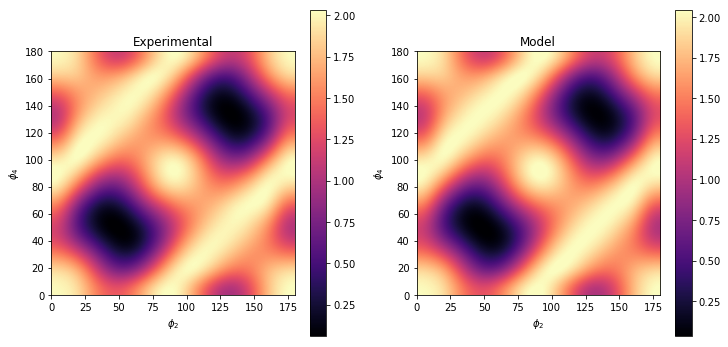

In [47]:
# Hacer el experimento
for ind1, angleDim1 in enumerate(angles2x):
    print("\n")
    for ind2, angleDim2 in enumerate(angles2y):
        pos = np.array([0, angleDim1, angleDim2, 0])
        delay = [0, 0, 0, 90]
        motors.move(
            positions = pos - theta0, velocities=Vels, kind='absolute',  verbose=False)
        intensities_2[ind1, ind2, :] = get_two_intensities(AIN_signal, AIN_ref, u=u3, d=d, verbose=True)
        Imodel2[ind1, ind2] = Intensity_Rotating_Elements(Mpol, pos*degrees, Ei=Ifuente)
intensity2 = intensities_2 - intensity_0
intensity2 = intensity2[:,:,0] * intensity2[:,:,1] / pol_dict["normal"]
# Plot results, 2D
plt.figure(figsize=(12, 6))   
plt.subplot(1,2,1)
plot_2d(angles2x, angles2y, intensity2, title='Experimental', xy_are_angles=False)
plt.subplot(1,2,2)
print(Imodel2.shape)
plot_2d(angles2x, angles2y, Imodel2, title='Model', xy_are_angles=False)

### Encontrar theta 0

In [11]:
def malus(par, theta, Iexp):
    return Iexp - (par[0] + par[1]*np.cos(theta-par[2])**2)

def buscar_theta_0_twined(Nangles=91, theta1=0, initial_pos=None, plot=False):
    # If no initial pos is introduced, use current pos 
    if initial_pos is None:
        _, initial_pos, _ = motors.get_position(verbose=False)
    initial_pos = initial_pos + [theta1, 0, 0, 0]
    # Move to it with first motor
    motors.move(positions = initial_pos, velocities=Vels, kind='absolute',  verbose=False)
    
    # Make a loop using the last motor
    angles = np.linspace(0,180, Nangles)
    intensity = np.zeros([Nangles,2])
    for i, th in enumerate(angles):
        motors.move(positions = initial_pos + [0, 0, 0, th], 
                    velocities=Vels, kind='absolute',  verbose=False)
        intensity[i,:] = medir_intensidades(verbose=False) - intensity_0
    # Find the maximum of intensity
    I_norm = intensity[:,0]/intensity[:,1]
    par1, success = optimize.leastsq(malus, [0, 1, 0], args=(angles*degrees, I_norm))
    th0_4 = (par1[2]/degrees) % 180
    # Plot
    if plot:
        print('Theta0_4 is {} deg.'.format(th0_4))
        plt.figure()                                                                                                                                                                                                                                                                                                                                                                                                                  
        plt.plot(angles, I_norm) 
        plt.xlabel('Angle (deg)')
        plt.ylabel('Norm. signal')
        plt.title('P2')
    
    # Loop with two last motors twined
    for i, th in enumerate(angles):
        motors.move(positions = initial_pos + [0, 0, th, th+th0_4], 
                    velocities=Vels, kind='absolute',  verbose=False)
        intensity[i,:] = medir_intensidades(verbose=False) - intensity_0
    # Find the maximum of intensity
    I_norm = intensity[:,0]/intensity[:,1]
    par1, success = optimize.leastsq(malus, [0, 1, 0], args=(angles*degrees, I_norm))
    th0_3 = (par1[2]/degrees) % 180
    print('End R2')
    if plot:
        print('Theta0_4 is {} deg.'.format(th0_3))
        plt.figure()                                                                                                                                                                                                                                                                                                                                                                                                                  
        plt.plot(angles, I_norm) 
        plt.xlabel('Angle (deg)')
        plt.ylabel('Norm. signal')
        plt.title('R2')
    
    # Loop with three last motors twined
    for i, th in enumerate(angles):
        motors.move(positions = initial_pos + [0, th, th+th0_3, th+th0_3+th0_4], 
                    velocities=Vels, kind='absolute',  verbose=False)
        intensity[i,:] = medir_intensidades(verbose=False) - intensity_0
    # Find the maximum of intensity
    I_norm = intensity[:,0]/intensity[:,1]
    par1, success = optimize.leastsq(malus, [0, 1, 0], args=(angles*degrees, I_norm))
    th0_2 = (par1[2]/degrees) % 180
    print('End R1')
    if plot:
        print('Theta0_4 is {} deg.'.format(th0_2))
        plt.figure()                                                                                                                                                                                                                                                                                                                                                                                                                  
        plt.plot(angles, I_norm) 
        plt.xlabel('Angle (deg)')
        plt.ylabel('Norm. signal')
        plt.title('R1')
    
    # Final calculation
    th0 = initial_pos + [0, th0_2, th0_2+th0_3, th0_2+th0_3+th0_4]
    th0 = th0 % 180
    return th0

In [12]:
def polarimeter_brute(par, angles, Iexp):
    Nangles = angles.size
    I_fit = np.zeros([Nangles,Nangles,Nangles])
    I_0 = Stokes()
    I_0.linear_light(intensity=par[3])
    M_brute = [pol_dict["Mr1"], pol_dict["Mr2"], pol_dict["Mp2"]]
    for i1, th1 in enumerate(angles):
        for i2, th2 in enumerate(angles):
            for i3, th3 in enumerate(angles):
                th = [th1-par[0], th2-par[1], th3-par[2]]
                I_fit[i1, i2, i3] = Intensity_Rotating_Elements(J=Mpol[1:4], th=th, Ei=I_0)
    return (Iexp-I_fit).flatten()
    

def buscar_theta_0_brute(Nangles=10, theta1=0, initial_pos=None, limits=[0,180]):
    # If no initial pos is introduced, use current pos 
    if initial_pos is None:
        _, initial_pos, _ = motors.get_position(verbose=False)
    initial_pos = initial_pos + [theta1, 0, 0, 0]
    # Move to it with first motor
    motors.move(positions = initial_pos, velocities=Vels, kind='absolute',  verbose=False)
    
    # Make three loops looking for the maximum
    angles = np.linspace(limits[0],limits[1], Nangles)
    I_norm = np.zeros([Nangles,Nangles,Nangles])
    for ind1, th1 in enumerate(angles):
        for ind2, th2 in enumerate(angles):
            for ind3, th3 in enumerate(angles):
                motors.move(positions = initial_pos + [0, th1, th2, th3], 
                            velocities=Vels, kind='absolute',  verbose=False)
                intensity = medir_intensidades(verbose=False) - intensity_0
                I_norm[ind1, ind2, ind3] = intensity[0]/intensity[1]
            
    # Find the maximum of intensity
    par1, success = optimize.leastsq(polarimeter_brute, [0, 0, 0, 1], args=(angles*degrees, I_norm))
    th0 = (np.array([0, par1[0], par1[1], par1[2]])/degrees)
    print('Difference is {} deg.'.format(th0))
    th0 = initial_pos + th0
    print('Theta0 is {} deg.'.format(th0))
    return th0

In [ ]:
th0_exp = buscar_theta_0_twined(Nangles=91, theta1=0, initial_pos=-theta0, plot=True)
print(th0_exp)
print(theta0)

In [46]:
limits = [-5, 5]
th0_exp = buscar_theta_0_brute(Nangles=9, theta1=0, initial_pos=-theta0, limits=limits)
print(th0_exp)
print(theta0)

Difference is [ 0.          5.41654537  4.90899957  7.35006949] deg.
Theta0 is [-172.02143604 -157.25569954  -50.87612692  -28.33958572] deg.
[-172.02143604 -157.25569954  -50.87612692  -28.33958572]
[ 172.02143604  162.67224491   55.78512649   35.6896552 ]
